In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt


In [4]:
# Load CIFAR-100 dataset with metadata
(dataset_train, dataset_test), dataset_info = tfds.load(
    'cifar100',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

# Normalization function
def preprocess_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)  # Scales to [0, 1]
    return image, label

# Define batch size and prefetch settings
BATCH_SIZE = 128
AUTOTUNE = tf.data.AUTOTUNE

# Prepare the training dataset
train_data = dataset_train.map(preprocess_image, num_parallel_calls=AUTOTUNE)
train_data = train_data.cache().shuffle(buffer_size=1024).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Prepare the test dataset
test_data = dataset_test.map(preprocess_image, num_parallel_calls=AUTOTUNE)
test_data = test_data.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

#one-hot-encode
def one_hot_encode(image, label):
    return image, tf.one_hot(label, depth=100)

train_data = train_data.map(one_hot_encode)
test_data = test_data.map(one_hot_encode)


2025-05-08 01:21:41.793046: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-05-08 01:21:41.793210: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-05-08 01:21:41.793217: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
I0000 00:00:1746660101.793551  497187 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1746660101.793910  497187 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


2025-05-08 01:21:45.825598: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-05-08 01:21:45.864921: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-05-08 01:21:45.866822: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


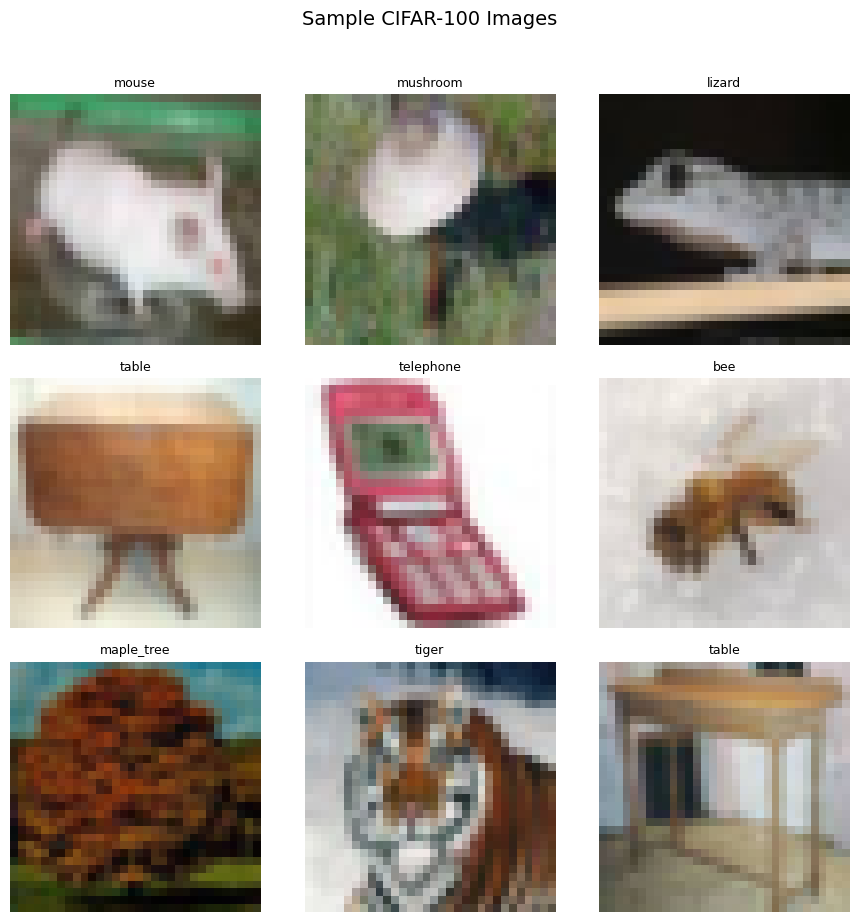

In [5]:
# Extract class names from dataset metadata
class_names = dataset_info.features['label'].names

# Function to display a batch of random CIFAR-100 images
def visualize_random_images(dataset, class_labels, num_images=9):
    plt.figure(figsize=(9, 9))
    for i, (img, lbl) in enumerate(dataset.shuffle(1000).take(num_images)):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(img.numpy())
        plt.title(class_labels[lbl.numpy()], fontsize=9)
        plt.axis("off")
    plt.suptitle("Sample CIFAR-100 Images", fontsize=14, y=1.02)
    plt.tight_layout()

# Show example images from training set
visualize_random_images(dataset_train, class_names)


In [6]:
from tensorflow.keras import layers, models, optimizers

# Custom CNN model builder function
def build_custom_cnn(input_shape=(32, 32, 3), num_classes=100):
    model = models.Sequential(name="CIFAR100_CustomCNN")
    
    # Block 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Dropout(0.3))

    # Block 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Dropout(0.3))

    # Block 3
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Dropout(0.5))

    # Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))
    
    return model

# Build and compile the model
cnn_base = build_custom_cnn()

# Functional API wrapper for final classification layer
input_tensor = layers.Input(shape=(32, 32, 3), name="input_image")
features = cnn_base(input_tensor)
output_tensor = layers.Dense(100, activation='softmax', name="class_prediction")(features)

model_custom = tf.keras.Model(inputs=input_tensor, outputs=output_tensor, name="CIFAR100_Classifier")

# Compile with updated API
model_custom.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',  
    metrics=['accuracy']
)

# Model Summary
model_custom.summary()
# Save a copy of the initial weights of the first Conv2D layer
initial_weights = model_custom.layers[1].get_weights()[0].copy()  # model.layers[1] is first Conv2D



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "CIFAR100_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ CIFAR100_CustomCNN (Sequential) │ (None, 128)            │     1,405,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ class_prediction (Dense)        │ (None, 100)            │        12,900 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,418,500 (5.41 MB)

 Trainable params: 1,416,580 (5.40 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callbacks for better training control
callbacks_list = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True, verbose=1)
]

# Training configuration
EPOCHS = 100

# Train the model
history = model_custom.fit(
    train_data,
    validation_data=test_data,
    epochs=EPOCHS,
    callbacks=callbacks_list,
    verbose=1
)

Epoch 1/100


2025-05-08 01:21:56.087694: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.0360 - loss: 5.3519
Epoch 1: val_accuracy improved from -inf to 0.04820, saving model to best_model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 27s 62ms/step - accuracy: 0.0360 - loss: 5.3506 - val_accuracy: 0.0482 - val_loss: 4.3200 - learning_rate: 0.0010
Epoch 2/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.0990 - loss: 4.2179
Epoch 2: val_accuracy improved from 0.04820 to 0.17230, saving model to best_model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 23s 57ms/step - accuracy: 0.0990 - loss: 4.2177 - val_accuracy: 0.1723 - val_loss: 3.5051 - learning_rate: 0.0010
Epoch 3/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.1341 - loss: 4.0241
Epoch 3: val_accuracy did not improve from 0.17230
391/391 ━━━━━━━━━━━━━━━━━━━━ 23s 58ms/step - accuracy: 0.1342 - loss: 4.0239 - val_accuracy: 0.1140 - val_loss: 4.0571 - learning_rate: 0.0010
Epoch 4/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.1747 - loss: 3.6098
Epoch 4: val_accuracy improved from 0.17230 to 0.25800, saving model to best_model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 23s 58ms/step - accuracy: 0.1747 - loss: 3.6096 - val_accuracy: 0.2580 - val_loss: 3.0813 - learning_rate: 0.0010
Epoch 5/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.2150 - loss: 3.2890
Epoch 5: val_accuracy improved from 0.25800 to 0.29900, saving model to best_model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - accuracy: 0.2150 - loss: 3.2889 - val_accuracy: 0.2990 - val_loss: 2.7618 - learning_rate: 0.0010
Epoch 6/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.2518 - loss: 3.0413
Epoch 6: val_accuracy improved from 0.29900 to 0.32330, saving model to best_model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - accuracy: 0.2518 - loss: 3.0412 - val_accuracy: 0.3233 - val_loss: 2.6237 - learning_rate: 0.0010
Epoch 7/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.2803 - loss: 2.8513
Epoch 7: val_accuracy improved from 0.32330 to 0.36100, saving model to best_model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - accuracy: 0.2803 - loss: 2.8513 - val_accuracy: 0.3610 - val_loss: 2.4481 - learning_rate: 0.0010
Epoch 8/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.3048 - loss: 2.7442
Epoch 8: val_accuracy did not improve from 0.36100
391/391 ━━━━━━━━━━━━━━━━━━━━ 24s 62ms/step - accuracy: 0.3048 - loss: 2.7442 - val_accuracy: 0.3409 - val_loss: 2.5742 - learning_rate: 0.0010
Epoch 9/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.3242 - loss: 2.6358
Epoch 9: val_accuracy improved from 0.36100 to 0.38630, saving model to best_model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 67ms/step - accuracy: 0.3242 - loss: 2.6358 - val_accuracy: 0.3863 - val_loss: 2.3122 - learning_rate: 0.0010
Epoch 10/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.3332 - loss: 2.5738
Epoch 10: val_accuracy improved from 0.38630 to 0.39780, saving model to best_model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 35s 89ms/step - accuracy: 0.3332 - loss: 2.5738 - val_accuracy: 0.3978 - val_loss: 2.3020 - learning_rate: 0.0010
Epoch 11/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.3485 - loss: 2.5103
Epoch 11: val_accuracy did not improve from 0.39780
391/391 ━━━━━━━━━━━━━━━━━━━━ 32s 82ms/step - accuracy: 0.3485 - loss: 2.5102 - val_accuracy: 0.3953 - val_loss: 2.2894 - learning_rate: 0.0010
Epoch 12/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.3648 - loss: 2.4483
Epoch 12: val_accuracy improved from 0.39780 to 0.40950, saving model to best_model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 79ms/step - accuracy: 0.3648 - loss: 2.4483 - val_accuracy: 0.4095 - val_loss: 2.2209 - learning_rate: 0.0010
Epoch 13/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.3710 - loss: 2.4306
Epoch 13: val_accuracy improved from 0.40950 to 0.42720, saving model to best_model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 32s 81ms/step - accuracy: 0.3710 - loss: 2.4305 - val_accuracy: 0.4272 - val_loss: 2.1409 - learning_rate: 0.0010
Epoch 14/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.3824 - loss: 2.3723
Epoch 14: val_accuracy did not improve from 0.42720
391/391 ━━━━━━━━━━━━━━━━━━━━ 36s 91ms/step - accuracy: 0.3824 - loss: 2.3723 - val_accuracy: 0.4255 - val_loss: 2.1413 - learning_rate: 0.0010
Epoch 15/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.3845 - loss: 2.3598
Epoch 15: val_accuracy improved from 0.42720 to 0.44610, saving model to best_model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 75ms/step - accuracy: 0.3845 - loss: 2.3597 - val_accuracy: 0.4461 - val_loss: 2.0539 - learning_rate: 0.0010
Epoch 16/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.3936 - loss: 2.3201
Epoch 16: val_accuracy did not improve from 0.44610
391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 74ms/step - accuracy: 0.3936 - loss: 2.3201 - val_accuracy: 0.4160 - val_loss: 2.1869 - learning_rate: 0.0010
Epoch 17/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.3993 - loss: 2.3005
Epoch 17: val_accuracy improved from 0.44610 to 0.45030, saving model to best_model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 78ms/step - accuracy: 0.3993 - loss: 2.3005 - val_accuracy: 0.4503 - val_loss: 2.0280 - learning_rate: 0.0010
Epoch 18/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.4006 - loss: 2.2742
Epoch 18: val_accuracy improved from 0.45030 to 0.45850, saving model to best_model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 76ms/step - accuracy: 0.4006 - loss: 2.2742 - val_accuracy: 0.4585 - val_loss: 1.9706 - learning_rate: 0.0010
Epoch 19/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.4143 - loss: 2.2400
Epoch 19: val_accuracy improved from 0.45850 to 0.47100, saving model to best_model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 74ms/step - accuracy: 0.4143 - loss: 2.2400 - val_accuracy: 0.4710 - val_loss: 1.9687 - learning_rate: 0.0010
Epoch 20/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.4195 - loss: 2.2144
Epoch 20: val_accuracy did not improve from 0.47100
391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 77ms/step - accuracy: 0.4195 - loss: 2.2144 - val_accuracy: 0.4654 - val_loss: 1.9939 - learning_rate: 0.0010
Epoch 21/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.4221 - loss: 2.2013
Epoch 21: val_accuracy did not improve from 0.47100
391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 76ms/step - accuracy: 0.4221 - loss: 2.2013 - val_accuracy: 0.4660 - val_loss: 1.9760 - learning_rate: 0.0010
Epoch 22/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.4295 - loss: 2.1915
Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 22: val_accuracy did not improve from 0.47100
391/391 ━━━━━━━━━━━━━━━━━━━━ 34s 87ms/step - accuracy: 0.4295 - loss: 

391/391 ━━━━━━━━━━━━━━━━━━━━ 34s 88ms/step - accuracy: 0.4486 - loss: 2.0753 - val_accuracy: 0.5025 - val_loss: 1.8117 - learning_rate: 5.0000e-04
Epoch 24/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.4630 - loss: 1.9980
Epoch 24: val_accuracy improved from 0.50250 to 0.51610, saving model to best_model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 32s 82ms/step - accuracy: 0.4630 - loss: 1.9979 - val_accuracy: 0.5161 - val_loss: 1.7484 - learning_rate: 5.0000e-04
Epoch 25/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.4716 - loss: 1.9677
Epoch 25: val_accuracy did not improve from 0.51610
391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 75ms/step - accuracy: 0.4716 - loss: 1.9677 - val_accuracy: 0.5088 - val_loss: 1.7855 - learning_rate: 5.0000e-04
Epoch 26/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.4738 - loss: 1.9512
Epoch 26: val_accuracy improved from 0.51610 to 0.52070, saving model to best_model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 80ms/step - accuracy: 0.4738 - loss: 1.9512 - val_accuracy: 0.5207 - val_loss: 1.7184 - learning_rate: 5.0000e-04
Epoch 27/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.4802 - loss: 1.9385
Epoch 27: val_accuracy did not improve from 0.52070
391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 75ms/step - accuracy: 0.4802 - loss: 1.9385 - val_accuracy: 0.5142 - val_loss: 1.7758 - learning_rate: 5.0000e-04
Epoch 28/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.4828 - loss: 1.9266
Epoch 28: val_accuracy did not improve from 0.52070
391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 76ms/step - accuracy: 0.4828 - loss: 1.9266 - val_accuracy: 0.5165 - val_loss: 1.7590 - learning_rate: 5.0000e-04
Epoch 29/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.4821 - loss: 1.9161
Epoch 29: val_accuracy improved from 0.52070 to 0.52770, saving model to best_model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 32s 81ms/step - accuracy: 0.4821 - loss: 1.9160 - val_accuracy: 0.5277 - val_loss: 1.7123 - learning_rate: 5.0000e-04
Epoch 30/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.4847 - loss: 1.8998
Epoch 30: val_accuracy did not improve from 0.52770
391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 75ms/step - accuracy: 0.4847 - loss: 1.8998 - val_accuracy: 0.5197 - val_loss: 1.7408 - learning_rate: 5.0000e-04
Epoch 31/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.4879 - loss: 1.8890
Epoch 31: val_accuracy did not improve from 0.52770
391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 80ms/step - accuracy: 0.4879 - loss: 1.8890 - val_accuracy: 0.5272 - val_loss: 1.7152 - learning_rate: 5.0000e-04
Epoch 32/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.4908 - loss: 1.8917
Epoch 32: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 32: val_accuracy did not improve from 0.52770
391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 79ms/step - accuracy: 0.4

391/391 ━━━━━━━━━━━━━━━━━━━━ 32s 81ms/step - accuracy: 0.5023 - loss: 1.8437 - val_accuracy: 0.5390 - val_loss: 1.6394 - learning_rate: 2.5000e-04
Epoch 34/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.5109 - loss: 1.7902
Epoch 34: val_accuracy improved from 0.53900 to 0.54280, saving model to best_model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 80ms/step - accuracy: 0.5109 - loss: 1.7902 - val_accuracy: 0.5428 - val_loss: 1.6483 - learning_rate: 2.5000e-04
Epoch 35/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5194 - loss: 1.7778
Epoch 35: val_accuracy did not improve from 0.54280
391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 77ms/step - accuracy: 0.5194 - loss: 1.7778 - val_accuracy: 0.5384 - val_loss: 1.6380 - learning_rate: 2.5000e-04
Epoch 36/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5168 - loss: 1.7742
Epoch 36: val_accuracy did not improve from 0.54280
391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 77ms/step - accuracy: 0.5168 - loss: 1.7742 - val_accuracy: 0.5374 - val_loss: 1.6525 - learning_rate: 2.5000e-04
Epoch 37/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5191 - loss: 1.7614
Epoch 37: val_accuracy did not improve from 0.54280
391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 76ms/step - accuracy: 0.5191 - loss: 1.7614 - val_accuracy: 0.5406 - val_loss: 1.6403 - learning_rate: 

391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 77ms/step - accuracy: 0.5201 - loss: 1.7645 - val_accuracy: 0.5431 - val_loss: 1.6331 - learning_rate: 2.5000e-04
Epoch 39/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5244 - loss: 1.7451
Epoch 39: val_accuracy did not improve from 0.54310
391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 77ms/step - accuracy: 0.5244 - loss: 1.7451 - val_accuracy: 0.5417 - val_loss: 1.6315 - learning_rate: 2.5000e-04
Epoch 40/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5285 - loss: 1.7297
Epoch 40: val_accuracy did not improve from 0.54310
391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 76ms/step - accuracy: 0.5285 - loss: 1.7297 - val_accuracy: 0.5407 - val_loss: 1.6362 - learning_rate: 2.5000e-04
Epoch 41/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5268 - loss: 1.7279
Epoch 41: val_accuracy did not improve from 0.54310
391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 77ms/step - accuracy: 0.5268 - loss: 1.7279 - val_accuracy: 0.5402 - val_loss: 1.6363 - learning_rate: 

391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 77ms/step - accuracy: 0.5331 - loss: 1.7024 - val_accuracy: 0.5532 - val_loss: 1.5895 - learning_rate: 1.2500e-04
Epoch 44/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5366 - loss: 1.6783
Epoch 44: val_accuracy improved from 0.55320 to 0.55400, saving model to best_model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 79ms/step - accuracy: 0.5366 - loss: 1.6782 - val_accuracy: 0.5540 - val_loss: 1.5881 - learning_rate: 1.2500e-04
Epoch 45/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5365 - loss: 1.6708
Epoch 45: val_accuracy did not improve from 0.55400
391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 78ms/step - accuracy: 0.5365 - loss: 1.6708 - val_accuracy: 0.5527 - val_loss: 1.5878 - learning_rate: 1.2500e-04
Epoch 46/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5417 - loss: 1.6681
Epoch 46: val_accuracy did not improve from 0.55400
391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 79ms/step - accuracy: 0.5417 - loss: 1.6681 - val_accuracy: 0.5527 - val_loss: 1.5879 - learning_rate: 1.2500e-04
Epoch 47/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.5431 - loss: 1.6518
Epoch 47: val_accuracy did not improve from 0.55400
391/391 ━━━━━━━━━━━━━━━━━━━━ 33s 84ms/step - accuracy: 0.5431 - loss: 1.6518 - val_accuracy: 0.5517 - val_loss: 1.5901 - learning_rate: 

391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 80ms/step - accuracy: 0.5441 - loss: 1.6531 - val_accuracy: 0.5547 - val_loss: 1.5791 - learning_rate: 1.2500e-04
Epoch 51/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5475 - loss: 1.6409
Epoch 51: val_accuracy did not improve from 0.55470
391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 76ms/step - accuracy: 0.5475 - loss: 1.6409 - val_accuracy: 0.5526 - val_loss: 1.5884 - learning_rate: 1.2500e-04
Epoch 52/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.5457 - loss: 1.6409
Epoch 52: val_accuracy improved from 0.55470 to 0.55530, saving model to best_model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 32s 82ms/step - accuracy: 0.5457 - loss: 1.6408 - val_accuracy: 0.5553 - val_loss: 1.5848 - learning_rate: 1.2500e-04
Epoch 53/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5458 - loss: 1.6345
Epoch 53: val_accuracy improved from 0.55530 to 0.55770, saving model to best_model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 77ms/step - accuracy: 0.5458 - loss: 1.6345 - val_accuracy: 0.5577 - val_loss: 1.5765 - learning_rate: 1.2500e-04
Epoch 54/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5505 - loss: 1.6348
Epoch 54: val_accuracy improved from 0.55770 to 0.55900, saving model to best_model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 75ms/step - accuracy: 0.5505 - loss: 1.6348 - val_accuracy: 0.5590 - val_loss: 1.5735 - learning_rate: 1.2500e-04
Epoch 55/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5499 - loss: 1.6313
Epoch 55: val_accuracy did not improve from 0.55900
391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 75ms/step - accuracy: 0.5499 - loss: 1.6313 - val_accuracy: 0.5563 - val_loss: 1.5703 - learning_rate: 1.2500e-04
Epoch 56/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5469 - loss: 1.6376
Epoch 56: val_accuracy did not improve from 0.55900
391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 74ms/step - accuracy: 0.5469 - loss: 1.6376 - val_accuracy: 0.5572 - val_loss: 1.5784 - learning_rate: 1.2500e-04
Epoch 57/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5495 - loss: 1.6352
Epoch 57: val_accuracy improved from 0.55900 to 0.55990, saving model to best_model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 76ms/step - accuracy: 0.5495 - loss: 1.6352 - val_accuracy: 0.5599 - val_loss: 1.5698 - learning_rate: 1.2500e-04
Epoch 58/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5484 - loss: 1.6323
Epoch 58: val_accuracy did not improve from 0.55990
391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 77ms/step - accuracy: 0.5484 - loss: 1.6323 - val_accuracy: 0.5557 - val_loss: 1.5810 - learning_rate: 1.2500e-04
Epoch 59/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5529 - loss: 1.6151
Epoch 59: val_accuracy improved from 0.55990 to 0.56140, saving model to best_model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 76ms/step - accuracy: 0.5529 - loss: 1.6151 - val_accuracy: 0.5614 - val_loss: 1.5695 - learning_rate: 1.2500e-04
Epoch 60/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5514 - loss: 1.6130
Epoch 60: val_accuracy did not improve from 0.56140
391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 73ms/step - accuracy: 0.5514 - loss: 1.6130 - val_accuracy: 0.5548 - val_loss: 1.5764 - learning_rate: 1.2500e-04
Epoch 61/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5507 - loss: 1.6223
Epoch 61: val_accuracy did not improve from 0.56140
391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 74ms/step - accuracy: 0.5507 - loss: 1.6223 - val_accuracy: 0.5553 - val_loss: 1.5740 - learning_rate: 1.2500e-04
Epoch 62/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5527 - loss: 1.6189
Epoch 62: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 62: val_accuracy did not improve from 0.56140
391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 74ms/step - accuracy: 0.55

391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 74ms/step - accuracy: 0.5614 - loss: 1.5896 - val_accuracy: 0.5627 - val_loss: 1.5553 - learning_rate: 6.2500e-05
Epoch 66/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5613 - loss: 1.5801
Epoch 66: val_accuracy did not improve from 0.56270
391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 75ms/step - accuracy: 0.5613 - loss: 1.5801 - val_accuracy: 0.5600 - val_loss: 1.5581 - learning_rate: 6.2500e-05
Epoch 67/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5592 - loss: 1.5874
Epoch 67: val_accuracy improved from 0.56270 to 0.56380, saving model to best_model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 75ms/step - accuracy: 0.5593 - loss: 1.5874 - val_accuracy: 0.5638 - val_loss: 1.5540 - learning_rate: 6.2500e-05
Epoch 68/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5596 - loss: 1.5887
Epoch 68: val_accuracy did not improve from 0.56380
391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 75ms/step - accuracy: 0.5596 - loss: 1.5887 - val_accuracy: 0.5617 - val_loss: 1.5589 - learning_rate: 6.2500e-05
Epoch 69/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5679 - loss: 1.5739
Epoch 69: val_accuracy did not improve from 0.56380
391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 77ms/step - accuracy: 0.5679 - loss: 1.5739 - val_accuracy: 0.5623 - val_loss: 1.5597 - learning_rate: 6.2500e-05
Epoch 70/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5631 - loss: 1.5678
Epoch 70: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 70: val_accuracy did not improve from 0.56380
391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 78ms/step - accuracy: 0.5

391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 77ms/step - accuracy: 0.5644 - loss: 1.5709 - val_accuracy: 0.5643 - val_loss: 1.5467 - learning_rate: 3.1250e-05
Epoch 72/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5645 - loss: 1.5679
Epoch 72: val_accuracy improved from 0.56430 to 0.56500, saving model to best_model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 75ms/step - accuracy: 0.5645 - loss: 1.5679 - val_accuracy: 0.5650 - val_loss: 1.5470 - learning_rate: 3.1250e-05
Epoch 73/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5659 - loss: 1.5650
Epoch 73: val_accuracy did not improve from 0.56500
391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 74ms/step - accuracy: 0.5659 - loss: 1.5650 - val_accuracy: 0.5633 - val_loss: 1.5460 - learning_rate: 3.1250e-05
Epoch 74/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5678 - loss: 1.5550
Epoch 74: val_accuracy did not improve from 0.56500
391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 74ms/step - accuracy: 0.5678 - loss: 1.5550 - val_accuracy: 0.5640 - val_loss: 1.5457 - learning_rate: 3.1250e-05
Epoch 75/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5681 - loss: 1.5508
Epoch 75: val_accuracy improved from 0.56500 to 0.56580, saving model to best_model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 75ms/step - accuracy: 0.5681 - loss: 1.5508 - val_accuracy: 0.5658 - val_loss: 1.5448 - learning_rate: 3.1250e-05
Epoch 76/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5668 - loss: 1.5600
Epoch 76: val_accuracy did not improve from 0.56580
391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 75ms/step - accuracy: 0.5668 - loss: 1.5600 - val_accuracy: 0.5646 - val_loss: 1.5457 - learning_rate: 3.1250e-05
Epoch 77/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5664 - loss: 1.5626
Epoch 77: val_accuracy did not improve from 0.56580
391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 75ms/step - accuracy: 0.5664 - loss: 1.5626 - val_accuracy: 0.5645 - val_loss: 1.5455 - learning_rate: 3.1250e-05
Epoch 78/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5673 - loss: 1.5468
Epoch 78: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 78: val_accuracy did not improve from 0.56580
391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 76ms/step - accuracy: 0.

391/391 ━━━━━━━━━━━━━━━━━━━━ 32s 81ms/step - accuracy: 0.5715 - loss: 1.5484 - val_accuracy: 0.5666 - val_loss: 1.5414 - learning_rate: 1.5625e-05
Epoch 82/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5677 - loss: 1.5533
Epoch 82: val_accuracy did not improve from 0.56660
391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 79ms/step - accuracy: 0.5677 - loss: 1.5533 - val_accuracy: 0.5648 - val_loss: 1.5393 - learning_rate: 1.5625e-05
Epoch 83/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5703 - loss: 1.5485
Epoch 83: val_accuracy improved from 0.56660 to 0.56700, saving model to best_model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 78ms/step - accuracy: 0.5703 - loss: 1.5485 - val_accuracy: 0.5670 - val_loss: 1.5396 - learning_rate: 1.5625e-05
Epoch 84/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5689 - loss: 1.5449
Epoch 84: val_accuracy did not improve from 0.56700
391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 78ms/step - accuracy: 0.5689 - loss: 1.5449 - val_accuracy: 0.5659 - val_loss: 1.5391 - learning_rate: 1.5625e-05
Epoch 85/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5742 - loss: 1.5408
Epoch 85: val_accuracy did not improve from 0.56700
391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 77ms/step - accuracy: 0.5742 - loss: 1.5408 - val_accuracy: 0.5656 - val_loss: 1.5388 - learning_rate: 1.5625e-05
Epoch 86/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5691 - loss: 1.5419
Epoch 86: val_accuracy did not improve from 0.56700
391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 78ms/step - accuracy: 0.5691 - loss: 1.5419 - val_accuracy: 0.5665 - val_loss: 1.5389 - learning_rate: 

391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 78ms/step - accuracy: 0.5726 - loss: 1.5318 - val_accuracy: 0.5673 - val_loss: 1.5379 - learning_rate: 1.5625e-05
Epoch 92/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.5701 - loss: 1.5552
Epoch 92: val_accuracy did not improve from 0.56730
391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 80ms/step - accuracy: 0.5701 - loss: 1.5552 - val_accuracy: 0.5653 - val_loss: 1.5373 - learning_rate: 1.5625e-05
Epoch 93/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5721 - loss: 1.5513
Epoch 93: val_accuracy did not improve from 0.56730
391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 79ms/step - accuracy: 0.5721 - loss: 1.5513 - val_accuracy: 0.5661 - val_loss: 1.5381 - learning_rate: 1.5625e-05
Epoch 94/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5720 - loss: 1.5431
Epoch 94: val_accuracy did not improve from 0.56730
391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 78ms/step - accuracy: 0.5720 - loss: 1.5431 - val_accuracy: 0.5662 - val_loss: 1.5373 - learning_rate: 

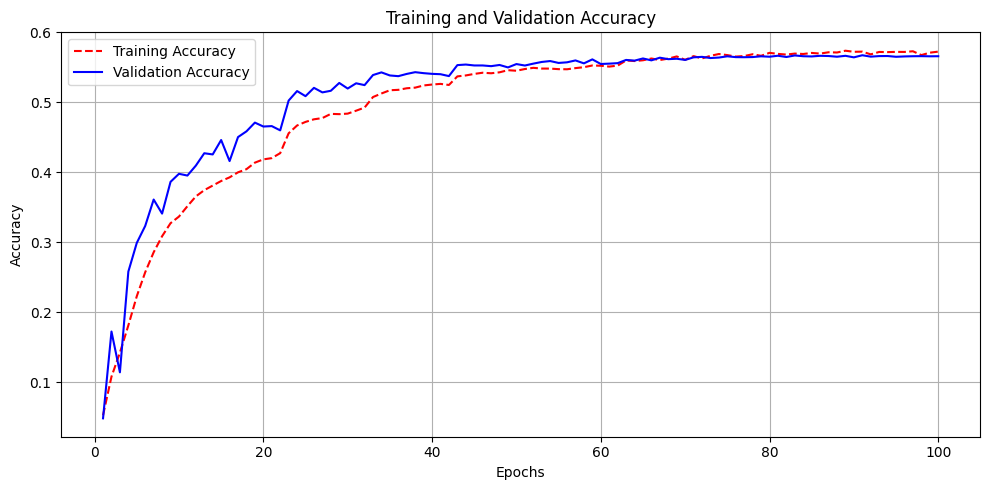

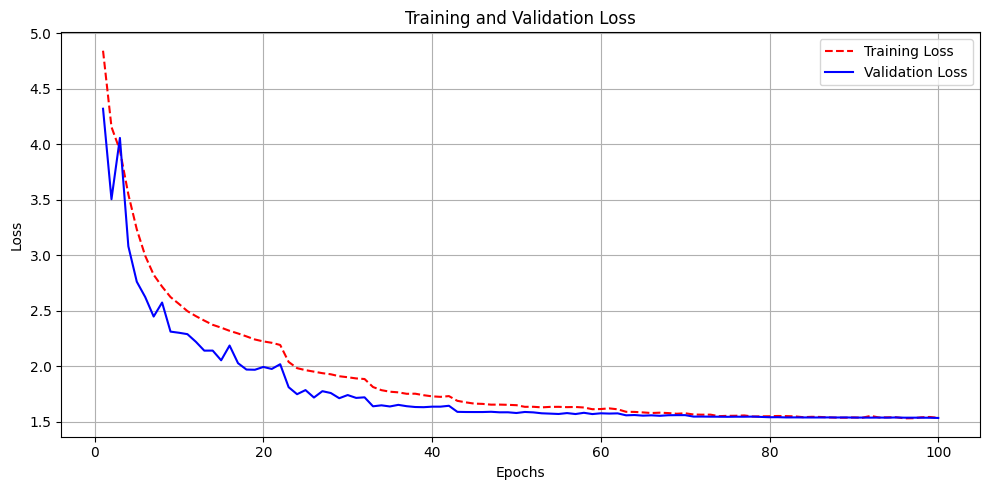

In [8]:
]

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Plot accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, acc, 'r--', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, loss, 'r--', label='Training Loss')
    plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_history(history)

In [9]:
final_val_acc = history.history['val_accuracy'][-1] * 100
print(f"Final Validation Accuracy: {final_val_acc:.2f}%")

Final Validation Accuracy: 56.59%


2025-05-08 02:13:32.261158: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


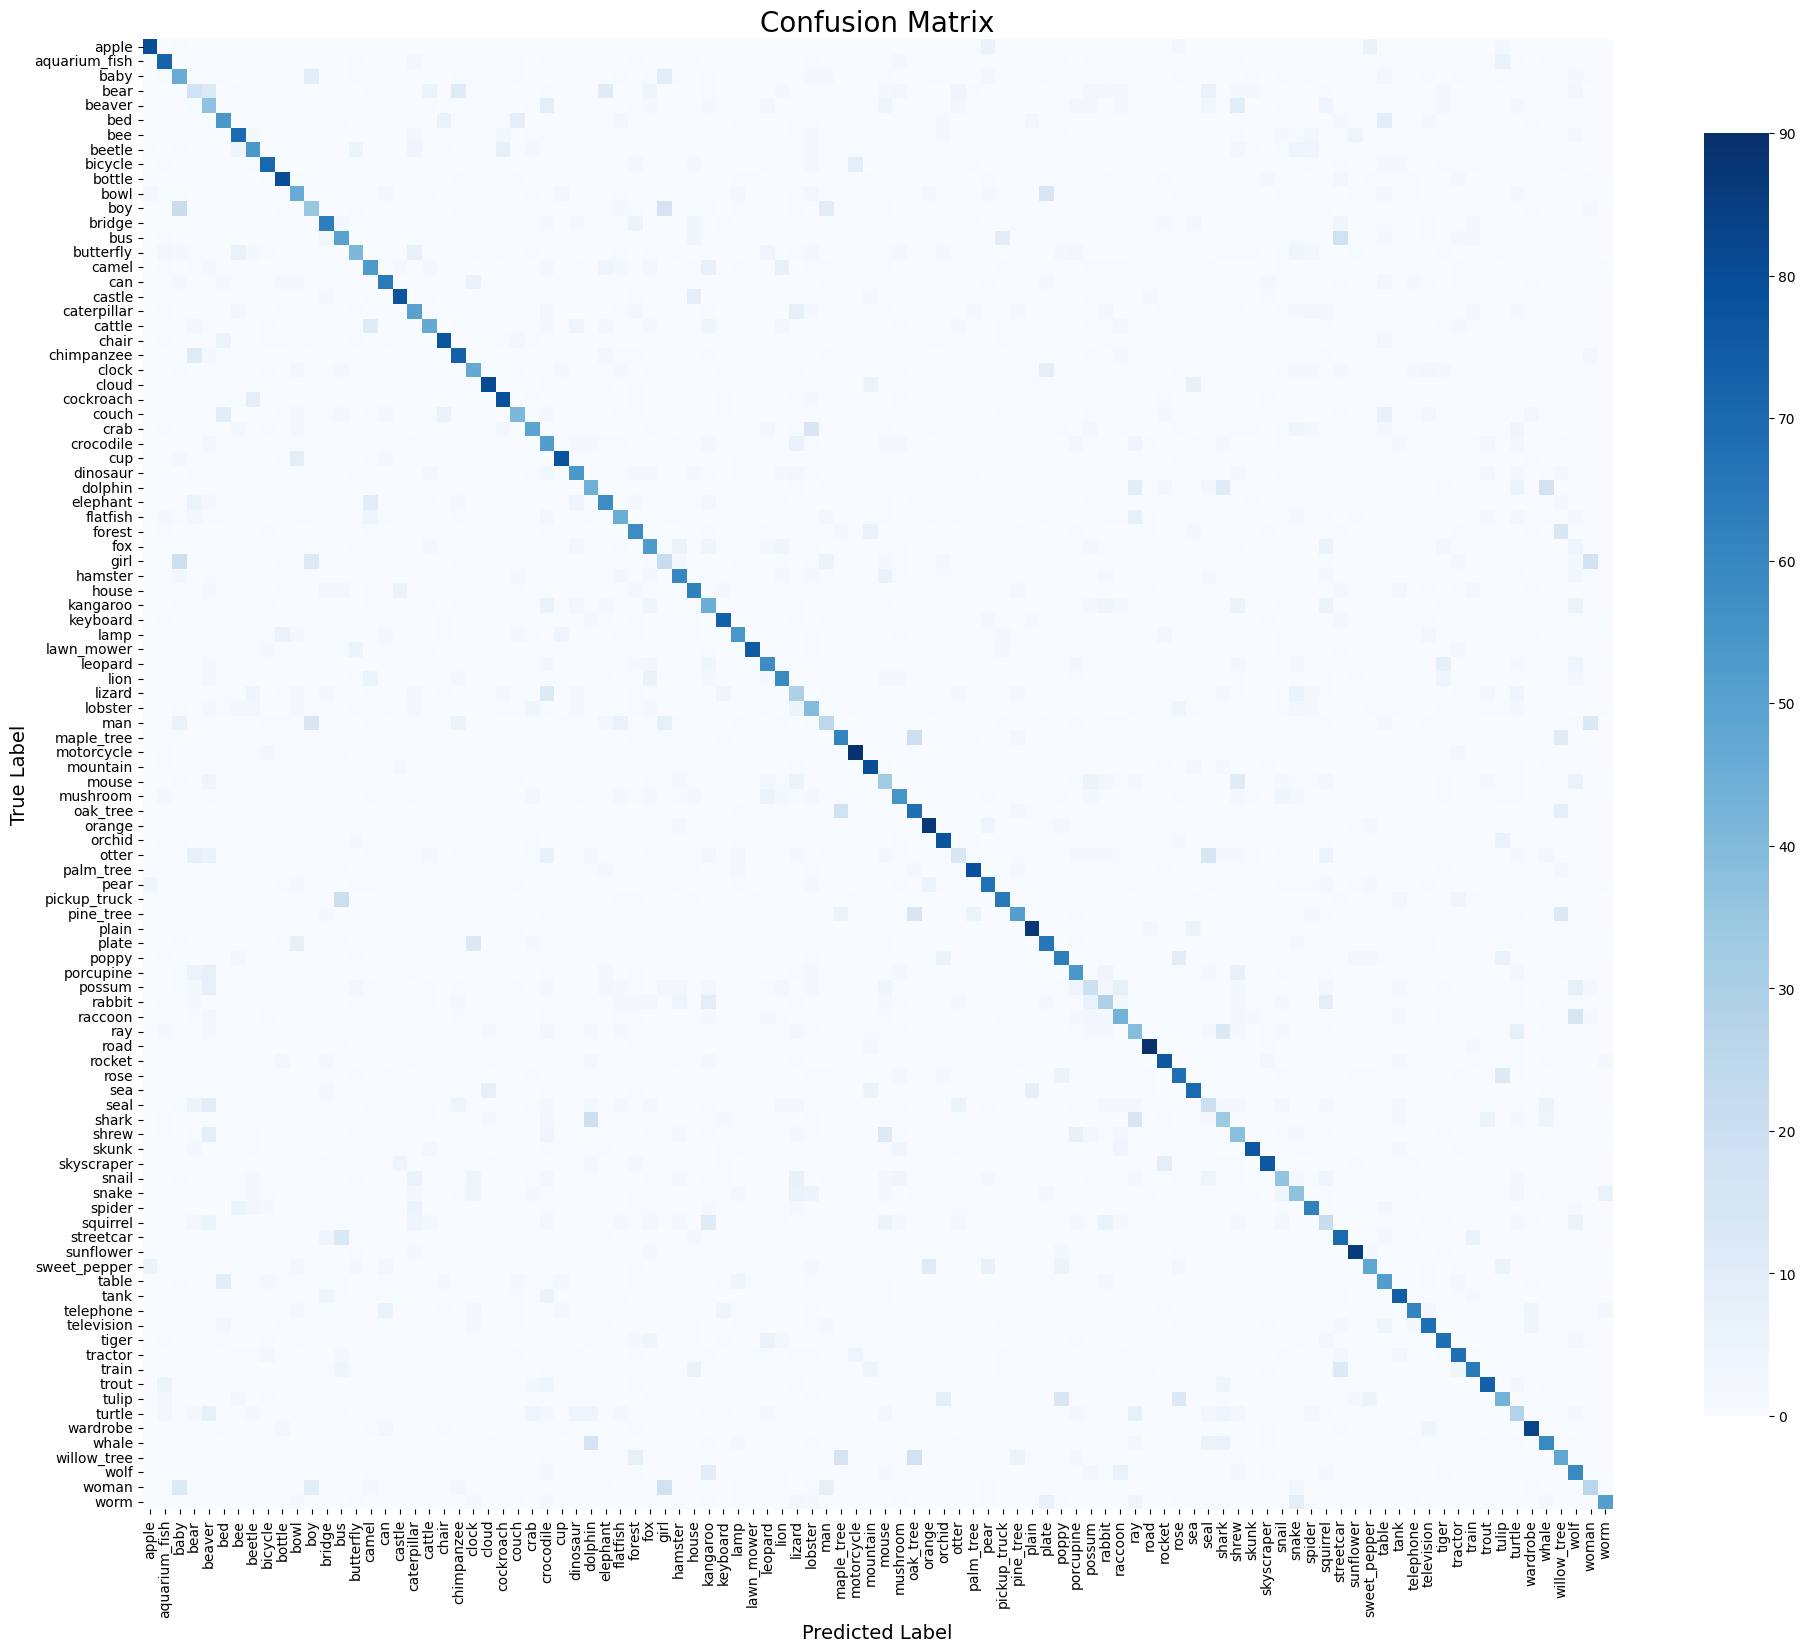

F1 Score (Macro): 0.5631
F1 Score (Weighted): 0.5631

Classification Report:
                precision    recall  f1-score   support

        apple     0.8421    0.8000    0.8205       100
aquarium_fish     0.6486    0.7200    0.6825       100
         baby     0.3538    0.4600    0.4000       100
         bear     0.2237    0.1700    0.1932       100
       beaver     0.2624    0.3700    0.3071       100
          bed     0.5347    0.5400    0.5373       100
          bee     0.6034    0.7000    0.6481       100
       beetle     0.5934    0.5400    0.5654       100
      bicycle     0.7320    0.7100    0.7208       100
       bottle     0.7477    0.8000    0.7729       100
         bowl     0.4646    0.4600    0.4623       100
          boy     0.3977    0.3500    0.3723       100
       bridge     0.6117    0.6300    0.6207       100
          bus     0.4630    0.5000    0.4808       100
    butterfly     0.5395    0.4100    0.4659       100
        camel     0.4907    0.5300    0.5

In [10]:
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import seaborn as sns

# Load class names from dataset info
_, dataset_info = tfds.load('cifar100', split='test', with_info=True)
class_names = dataset_info.features['label'].names

# Collect predictions and true labels
y_true = []
y_pred = []

for images, labels in test_data:
    preds = model_custom.predict(images, verbose=0)
    
    # Convert from one-hot to class index
    true_classes = tf.argmax(labels, axis=1).numpy()
    pred_classes = tf.argmax(preds, axis=1).numpy()
    
    y_true.extend(true_classes)
    y_pred.extend(pred_classes)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix with class names
plt.figure(figsize=(20, 18))
sns.heatmap(conf_matrix,
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            square=True,
            cbar_kws={"shrink": 0.75})
plt.title("Confusion Matrix", fontsize=20)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# F1 Score
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

print(f"F1 Score (Macro): {f1_macro:.4f}")
print(f"F1 Score (Weighted): {f1_weighted:.4f}")

# Detailed classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=class_names, digits=4))


In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Access trained weights from the first Conv2D layer
trained_weights = model_custom.layers[1].get_weights()[0]  # shape: (3, 3, 3, 64)

# Normalize for display
def normalize_weights(w):
    w_min = w.min()
    w_max = w.max()
    return (w - w_min) / (w_max - w_min)

# Number of filters to display
num_filters = 6

# Compare side-by-side
plt.figure(figsize=(12, 6))
for i in range(num_filters):
    # Before training
    plt.subplot(2, num_filters, i+1)
    f = normalize_weights(initial_weights[:, :, :, i])
    plt.imshow(f)
    plt.axis('off')
    plt.title(f'Init {i+1}')

    # After training
    plt.subplot(2, num_filters, num_filters + i + 1)
    f = normalize_weights(trained_weights[:, :, :, i])
    plt.imshow(f)
    plt.axis('off')
    plt.title(f'Trained {i+1}')

plt.suptitle("🎯 First Conv2D Layer Filters: Before vs After Training", fontsize=14)
plt.tight_layout()
plt.show()
final_val_acc = history.history['val_accuracy'][-1] * 100
print(f"Final Validation Accuracy (EfficientNetB0): {final_val_acc:.2f}%")

NameError: name 'model_custom' is not defined

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import os

# Set batch size and image size
batch_size = 128
image_size = (224, 224)

# Load CIFAR-100 dataset
(ds_train, ds_val), ds_info = tfds.load(
    "cifar100",
    split=["train[:80%]", "train[80%:]"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)
num_classes = ds_info.features['label'].num_classes

# Preprocessing function (generalized for pretrained models)
def preprocess(image, label):
    image = tf.image.resize(image, image_size)
    image = tf.keras.applications.densenet.preprocess_input(image)  # works for all models if you used this before
    label = tf.one_hot(label, depth=num_classes)
    return image, label

val_ds = ds_val.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Model folder map
model_paths = {
    "Custom CNN": "DLAssignment-1/My_Model/model_custom.h5",  # Add accuracy manually
    "ResNet-50": "DLAssignment-1/ResNet50/model.keras",
    "VGG-19": "DLAssignment-1/VGG19/model.keras",
    "DenseNet-121": "DLAssignment-1/Dn/model.keras",
    "EfficientNetB0": "DLAssignment-1/ResNet50/model.keras"
}

# Store results
results = {}

# Add your custom CNN accuracy manually
results["Custom CNN"] = 56.6  # Example

# Evaluate pretrained models
for name, path in model_paths.items():
    if path is None:
        continue
    print(f"🔍 Evaluating {name}...")
    model = tf.keras.models.load_model(path)
    loss, acc = model.evaluate(val_ds, verbose=0)
    results[name] = acc * 100  # Convert to %

# Plotting
plt.figure(figsize=(10, 6))
names = list(results.keys())
scores = list(results.values())

bars = plt.bar(names, scores, color='skyblue')
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width() / 2, score + 0.5, f'{score:.2f}%', ha='center', fontsize=10)

plt.title("Model Accuracy Comparison on CIFAR-100 (Validation Set)")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 80)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("images/model_accuracy_comparison.png", dpi=300)
plt.show()
